In [2]:
# Load the main libraries
library(EpiModel)
library(tidyverse)
library(lubridate)
library(incidence)

Loading required package: deSolve
Loading required package: networkDynamic
Loading required package: network
network: Classes for Relational Data
Version 1.16.0 created on 2019-11-30.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.


networkDynamic: version 0.10.1, created on 2020-01-16
Copyright (c) 2020, Carter T. Butts, University of California -- Irvine
                    Ayn Leslie-Cook, University of Washington
                    Pavel N. Krivitsky, University of Wollongong
                    Skye Bender-deMoll, University of Washington
                    with contributions from
                    Z

## Type 1
https://blog.ephorie.de/epidemiology-how-contagious-is-novel-coronavirus-2019-ncov

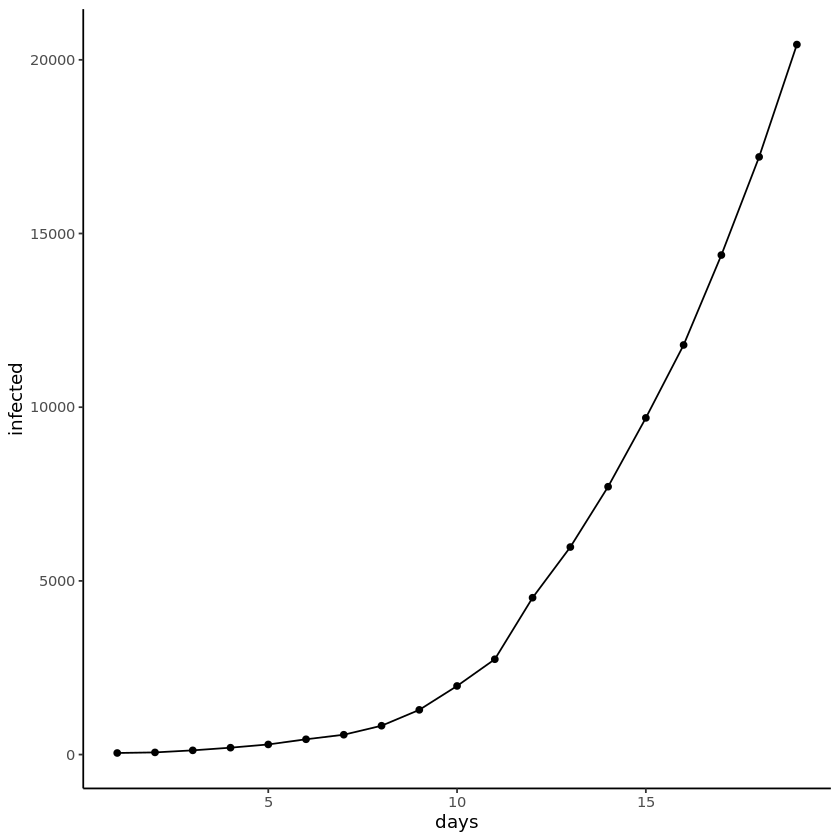

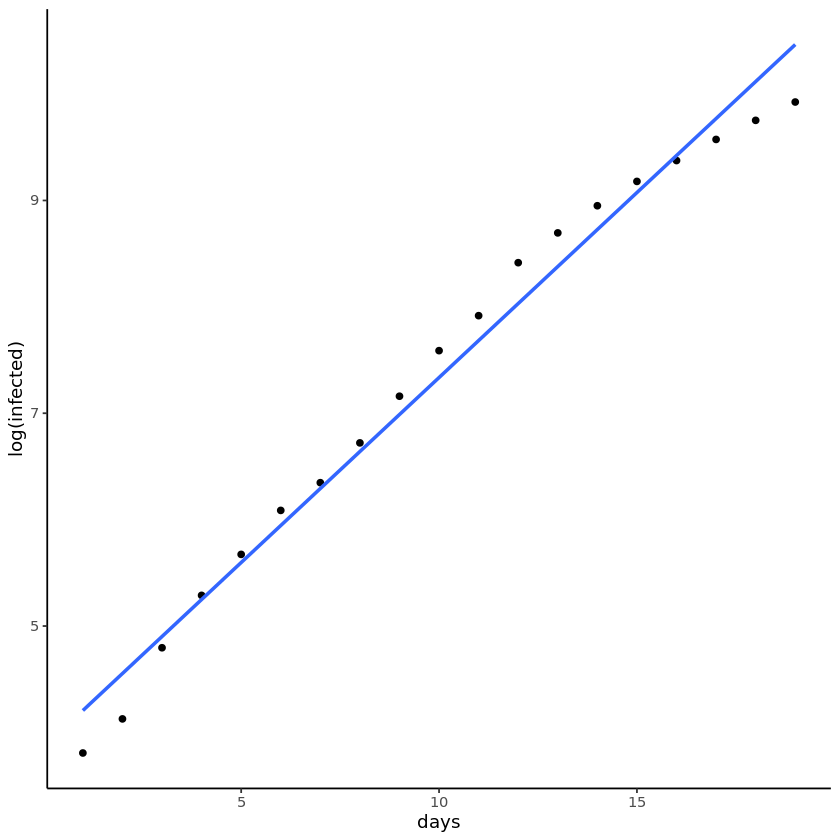

In [18]:
infected <- c(45, 62, 121, 198, 291, 440, 571,
             830, 1287, 1975, 2744, 4515,
             5974, 7711, 9692, 11791, 14380,
             17205, 20440)
days <- 1:(length(infected))
N <- 1400000000

mydata <- as.data.frame(cbind(infected, days))

mydata %>% 
 ggplot(aes(x = days, y = infected)) +
 geom_point() +
 geom_line() +
 theme_classic()

mydata %>%
 ggplot(aes(x = days, y = log(infected))) +
 geom_point() +
 geom_smooth(method = lm, se = F) +
 theme_classic()

## SIR
dS/dt = - beta * I * S / N where
dS/dt = rate of Susceptible population
beta = force of infection and is a factor of likelihood of action of a susceptible person meeting with an infected person and risk of transmission of the illness (in this case beta = composite of the risk of transmission of the illness)
I = number of infected
S = number of susceptible
N = total number of people in the population we are studying


dI/dt = beta * I * S / N - gamma * I

dI/dt = rate of infected people
gamma = the rate at which people recover or are removed from the pool
gamma = 1 / D where D = duration of the illness 

dR/dt = gamma * I

From here, we get the following code


In [19]:
sir <- function(time, state, params){
    params <- as.list(c(state, params))
    with(params, {
        dS <- - beta * I * S / N
        dI <- beta * I * S / N - gamma * I
        dR <- gamma * I
        list(c(dS, dI, dR))
    })
}

## Fit the model to the data
- Need a solver for differential eqn
 - Provided by ode() from library(deSolve)
- Need an optimiser
 - provided by optim() from base R
- Minimise the sum of squares between observed number of cases and predicted number of cases from model

rss(beta, gamma) = sum(I(t) - I_hat(t))^2

Code follows

In [20]:
# initialise
init <- c(S = N - infected[1],
          I = infected[1],
          R = 0
         )
rss <- function(params){
    names(params) <- c("beta", "gamma")
    out <- ode(y = init,
              times = days,
              func = sir,
              parms = params)
    fit <- out[,3]
    sum((infected - fit)^2)
}

optimised <- optim(c(0.5, 0.5),
                  rss,
                  method = "L-BFGS-B",
                  lower = c(0,0),
                  upper = c(1,1))
optimised_params <- setNames(optimised$par,
                            c("beta", "gamma"))


In [21]:
optimised_params #optimised parameters, beta and gamma

beta     gamma 
0.6746089 0.3253912

In [22]:
t <- 1:70 # how many days we want to run
fit <- data.frame(ode(y = init,
                     times = t,
                     func = sir,
                     parms = optimised_params))

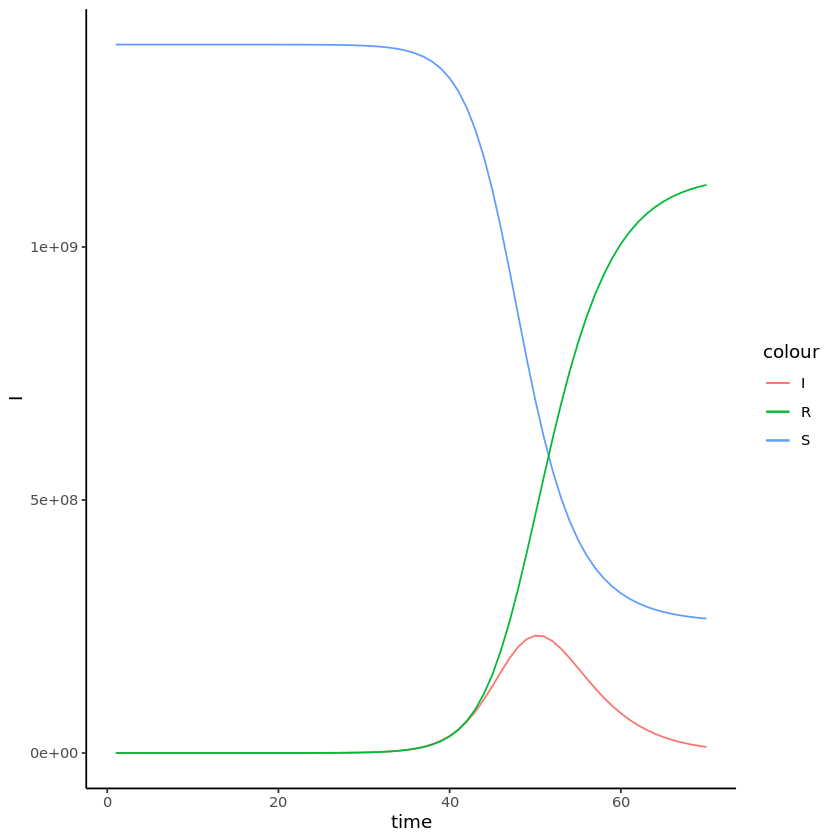

In [35]:
# Let's plot the rate of infection
fit %>%
 ggplot(aes(x = time)) +
 geom_line(aes(y = I, colour = "I")) +
 geom_line(aes(y = S, colour = "S")) +
 geom_line(aes(y = R, colour = "R")) +
 theme_classic()

In [36]:
## estimate R0 and max deaths
r0 <- setNames(optimised_params["beta"] / optimised_params["gamma"],
              "R0")
r0

R0 
2.073224

In [37]:
# Height of pandemic
fit[fit$I == max(fit$I), "I", drop = F]

,I
,<dbl>
50,232001865


In [40]:
# number of cases with 2% CFR
round(max(fit$I) * 0.002, 0)

[1] 464004

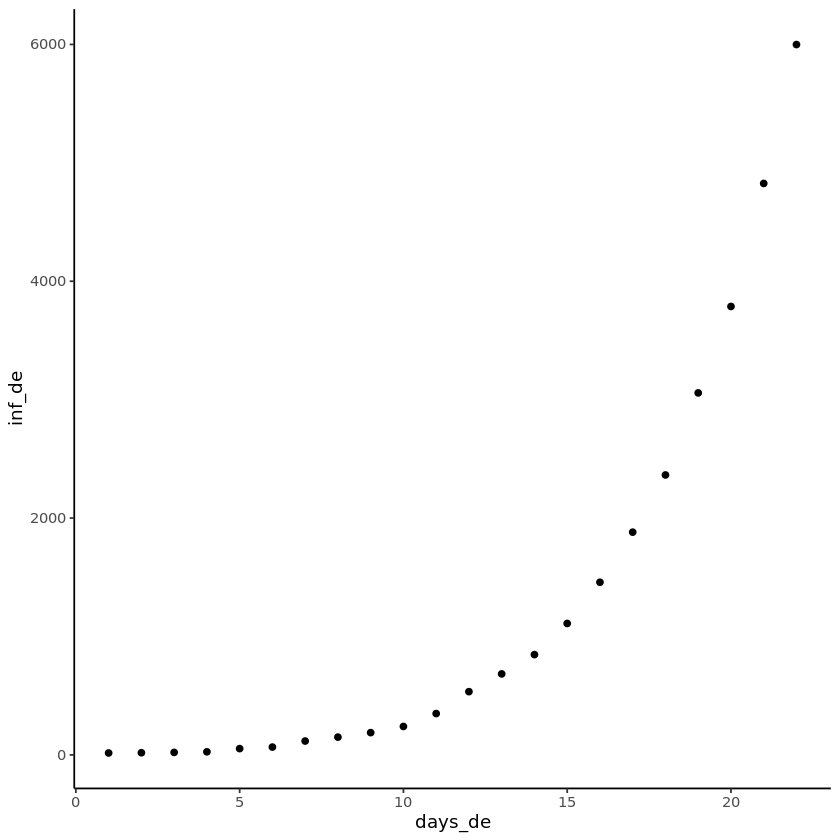

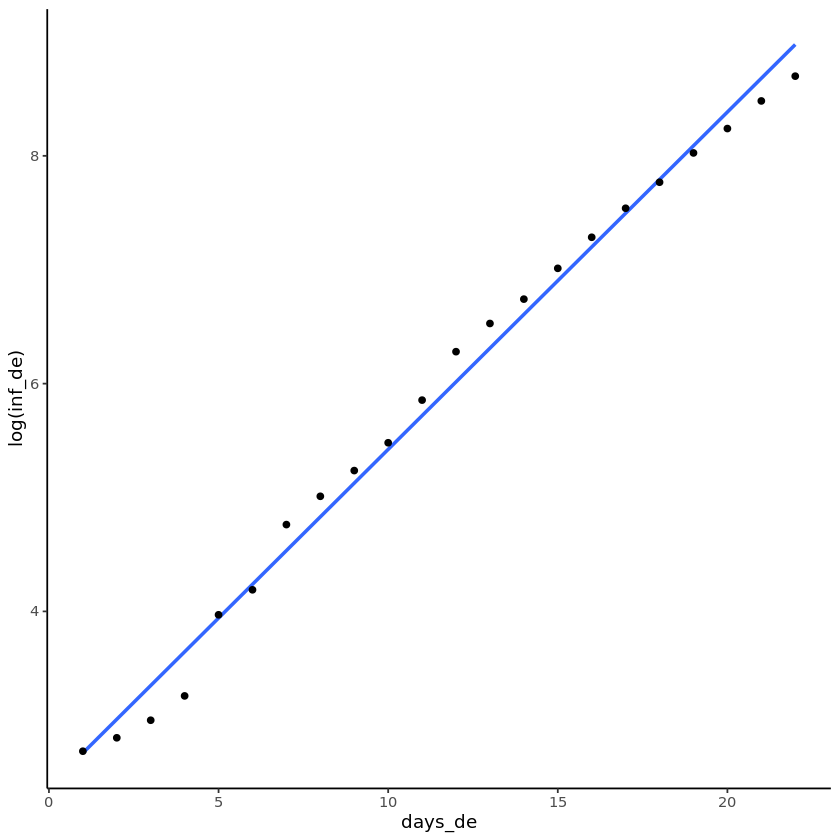

In [47]:
## the case for Germany
inf_de <- c(16, 18, 21, 26, 53, 
           66, 117, 150, 188,
           240, 349, 534, 684,
           847, 1110, 1458, 1881,
           2364, 3057, 3787, 4826, 5999)
days_de <- 1:length(inf_de)
N_de <- 83149300

data_de <- as.data.frame(cbind(days_de, inf_de))

## graph the data

ggplot(data_de, aes(x = days_de)) +
 geom_point(aes(y = inf_de)) +
 theme_classic()

ggplot(data_de) +
 geom_smooth(aes(x = days_de, y = log(inf_de)), 
            method = lm, se = F) +
 geom_point(aes(x = days_de, y = log(inf_de))) +
 theme_classic()
 

In [68]:
## first define the sir function

sir_de <- function(time, state, params){
    params <- as.list(c(state, params))
    with(params, {
        dS <- - beta * I_de * S_de / N_de
        dI <- beta * I_de * S_de / N_de - gamma * I_de
        dR <- gamma * I_de
        list(c(dS, dI, dR))
    })
}

## then initialise 
init_de <- c(S_de = N_de - inf_de[1],
          I_de = inf_de[1],
          R_de = 0
         )
## get the minimised sum of squares

rss_de <- function(params){
    names(params) <- c("beta", "gamma")
    out <- ode(y = init_de,
              times = days_de,
              func = sir_de,
              parms = params)
    fit <- out[,3]
    sum((inf_de - fit)^2)
}

## optimise the model

optimised_de <- optim(c(0.5, 0.5),
                  rss_de,
                  method = "L-BFGS-B",
                  lower = c(0,0),
                  upper = c(1,1))
optimised_params_de <- setNames(optimised$par,
                            c("beta", "gamma"))
## set the time
t_de <- 1:80 # time in days

## evaluate the model 
fit_de <- data.frame(ode(y = init_de,
                        times = t_de,
                        func = sir_de,
                        parm = optimised_params_de ))

## estimate the R0

r0_de <- setNames(optimised_params_de["beta"] / optimised_params_de["gamma"],
                 "R0")

# height of pandemic
ht_de <- fit_de[fit_de$I_de == max(fit_de$I_de),
               "I_de",
               drop = F]

## maximum infected
max_infected_de <- round(max(fit_de$I_de), 0)

## severe cases (20% cases severe)

severe_cases = round(0.20 * max_infected_de, 0)

## how many will need intensive care
## 6% of infected cases

intensive_de <- round(max_infected_de * 0.06, 0)

## possible deaths 0.7% fatality

poss_deaths_de <- round(max_infected_de * 0.007, 0)




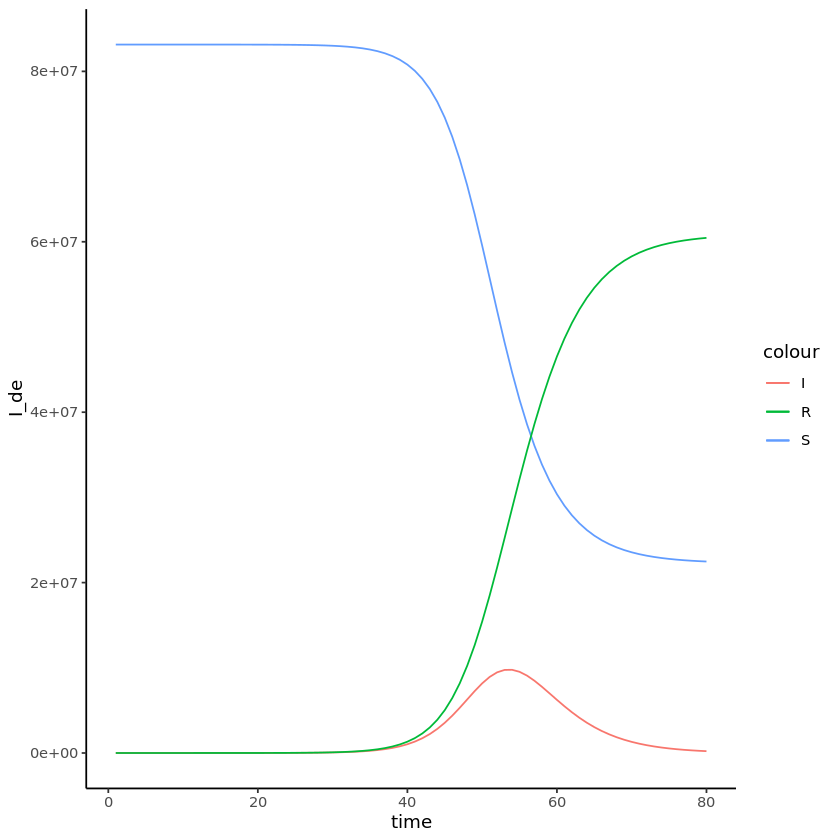

In [71]:
## graph for Germany
fit_de %>%
  ggplot(aes(x = time )) +
   geom_line(aes(y = I_de, colour = "I")) +
   geom_line(aes(y = S_de, colour = "S")) +
   geom_line(aes(y = R_de, colour = "R")) +
   theme_classic()

In [70]:
fit_de %>% head()

time,S_de,I_de,R_de
<dbl>,<dbl>,<dbl>,<dbl>
1,83149284,16.00000,0.000000
2,83149272,21.28719,6.615387
3,83149256,28.32153,15.416827
4,83149235,37.68035,27.126696
5,83149207,50.13181,42.706110
6,83149170,66.69778,63.433675


In [3]:
## the case for New Zealand (will model only till 26th March)
## get the data from web (JHU CSSE)
rawdata <- read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)
See spec(...) for full column specifications.


In [4]:
## data
rawdata %>% head()

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,⋯,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,⋯,24,40,40,74,84,94,110,110,120,170
NA,Albania,41.1533,20.1683,0,0,0,0,0,0,⋯,76,89,104,123,146,174,186,197,212,223
NA,Algeria,28.0339,1.6596,0,0,0,0,0,0,⋯,139,201,230,264,302,367,409,454,511,584
NA,Andorra,42.5063,1.5218,0,0,0,0,0,0,⋯,88,113,133,164,188,224,267,308,334,370
NA,Angola,-11.2027,17.8739,0,0,0,0,0,0,⋯,2,2,3,3,3,4,4,5,7,7
NA,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,⋯,1,1,3,3,3,7,7,7,7,7


In [5]:
# rename country/Region to country and remove province and lat long first
rawdata1 <- rawdata %>%
  rename(country = `Country/Region`) %>%
  select(-`Province/State`, -Lat, -Long) %>%
  pivot_longer(-country,
              names_to = "mo_day_yr",
              values_to = "cases") %>%
  mutate(date = mdy(mo_day_yr) ) %>%
  select(-mo_day_yr)

nzdata <- rawdata1 %>%
   filter(country == "New Zealand") %>%
   filter(cases >= 1)
   


In [6]:
nzdata %>% 
  arrange(date) %>%
  head(20) %>%
  write_csv("twenty.csv")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


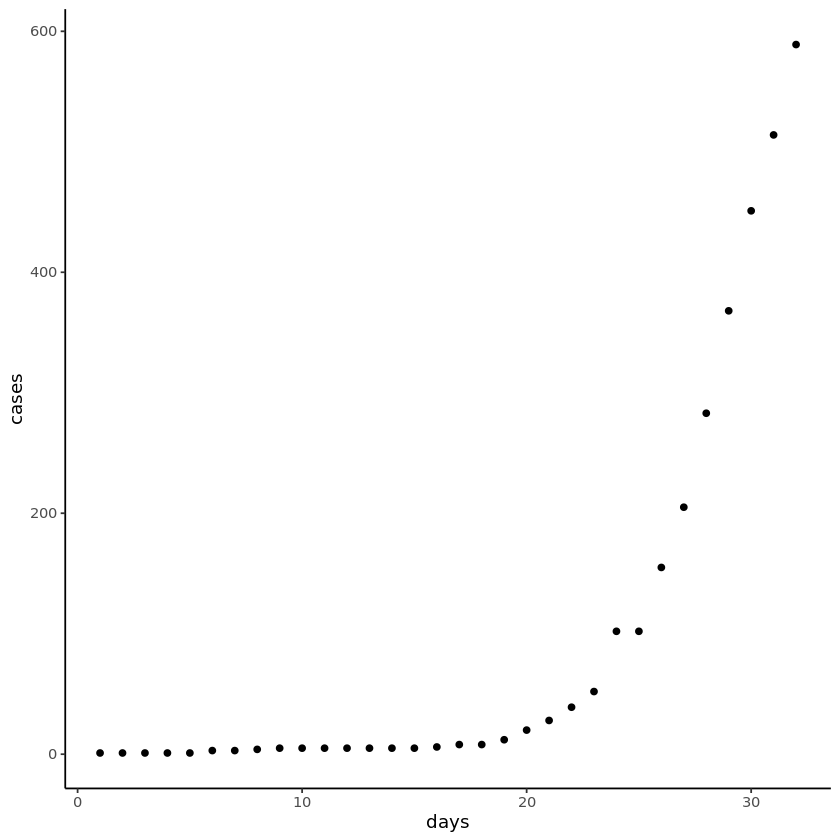

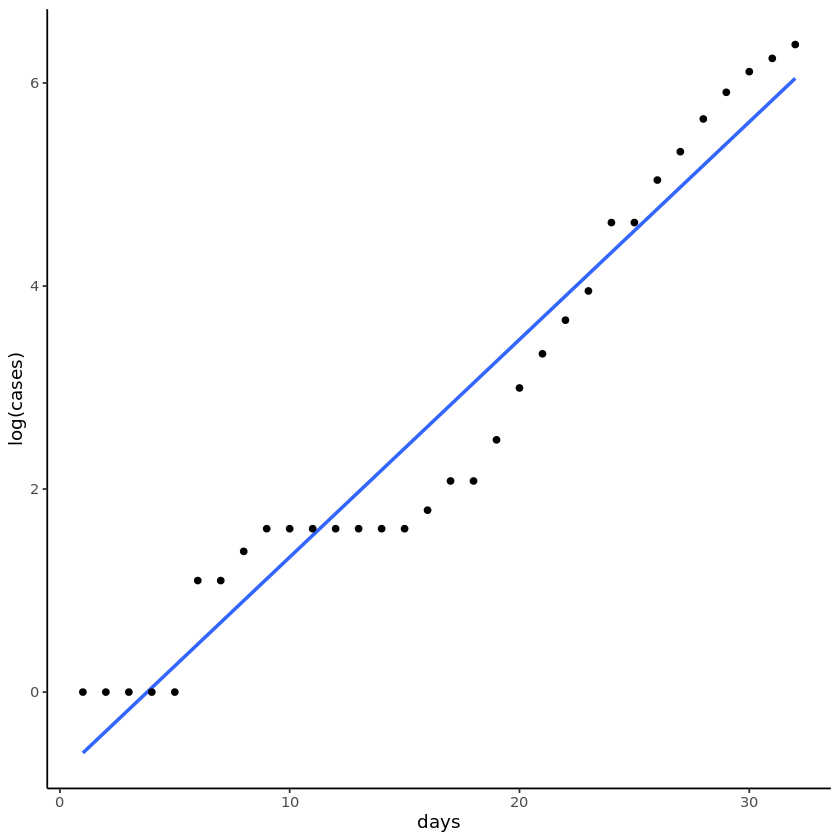

In [101]:
# set the data for NZ
data_nz <- nzdata %>%
  mutate(days = 1:length(cases))

inf_nz <- data_nz$cases
days_nz <- data_nz$days
N_nz <- 5000000 # population of NZ 5 million

# draw the graph of infections
# point plot, we pick up from 30 days onwards from 22nd February
ggplot(data_nz, aes(x = days)) +
  geom_point(aes(y = cases)) +
  theme_classic() +
  ggsave("cases.jpg")

# line plot along log scale
data_nz %>%
  ggplot(aes(x = days)) +
  geom_smooth(method = lm,
             aes(y = log(cases)),
              se = F
             ) +
  geom_point(aes(y = log(cases))) +
  theme_classic() +
  ggsave("logplot.jpg")
  
  

In [122]:
## first define the sir function

sir_nz <- function(time, state, params){
    params <- as.list(c(state, params))
    with(params, {
        dS <- - beta * I_nz * S_nz / N_nz
        dI <- beta * I_nz * S_nz / N_nz - gamma * I_nz
        dR <- gamma * I_nz
        list(c(dS, dI, dR))
    })
}

## then initialise 
init_nz <- c(S_nz = N_nz - inf_nz[1],
          I_nz = inf_nz[1],
          R_nz = 0
         )
## get the minimised sum of squares

rss_nz <- function(params){
    names(params) <- c("beta", "gamma")
    out <- ode(y = init_nz,
              times = days_nz,
              func = sir_nz,
              parms = params)
    fit <- out[,3]
    sum((inf_nz - fit)^2)
}

## optimise the model

optimised_nz <- optim(c(0.5, 0.5),
                  rss_nz,
                  method = "L-BFGS-B",
                  lower = c(0,0),
                  upper = c(1,1))
optimised_params_nz <- setNames(optimised$par,
                            c("beta", "gamma"))
## set the time
t_nz <- 1:80 # time in days

## evaluate the model 
fit_nz <- data.frame(ode(y = init_nz,
                        times = t_nz,
                        func = sir_nz,
                        parm = optimised_params_nz ))

## estimate the R0

r0_nz <- setNames(optimised_params_nz["beta"] / optimised_params_nz["gamma"],
                 "R0")

# height of pandemic
ht_nz <- fit_nz[fit_nz$I_nz == max(fit_nz$I_nz),
               "I_nz",
               drop = F]

## maximum infected
max_infected_nz <- round(max(fit_nz$I_nz), 0)

## severe cases (20% cases severe)

severe_cases_nz = round(0.20 * max_infected_nz, 0)

## how many will need intensive care
## 6% of infected cases

intensive_nz <- round(max_infected_nz * 0.06, 0)

## possible deaths 0.7% fatality

poss_deaths_nz <- round(max_infected_nz * 0.007, 0)

composite_nums <- cbind(r0_nz, max_infected_nz,
                           severe_cases_nz,
                           intensive_nz,
                           poss_deaths_nz)

In [105]:
fit_nz %>% head()

time,S_nz,I_nz,R_nz
<dbl>,<dbl>,<dbl>,<dbl>
1,4999999,1.000000,0.0000000
2,4999998,1.330450,0.4134627
3,4999997,1.770096,0.9635528
4,4999996,2.355024,1.6954211
5,4999994,3.133239,2.6691329
6,4999992,4.168614,3.9646079


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


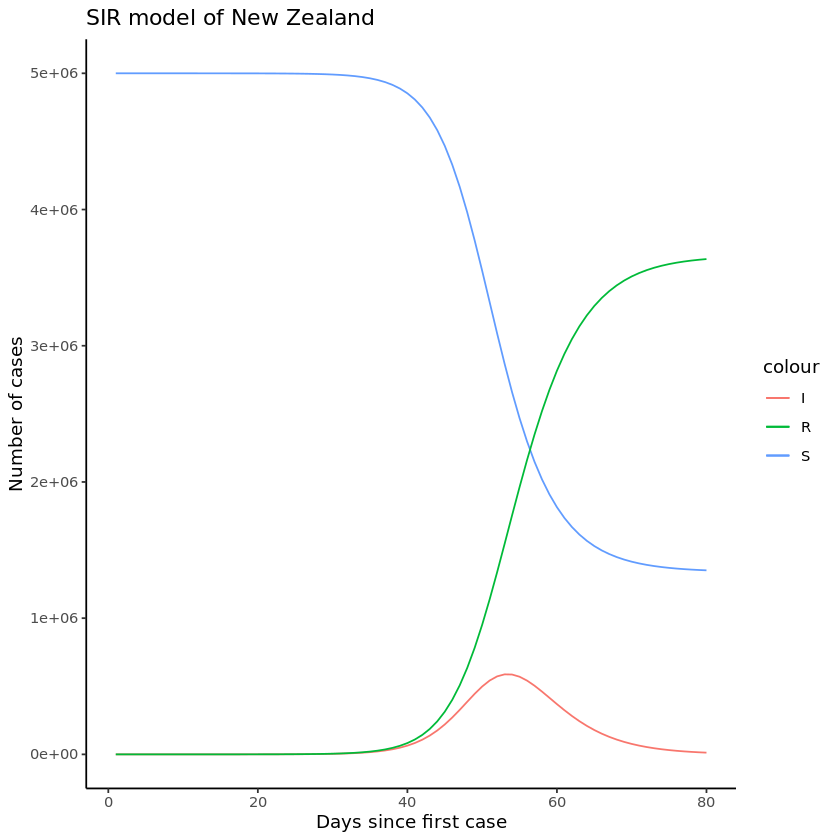

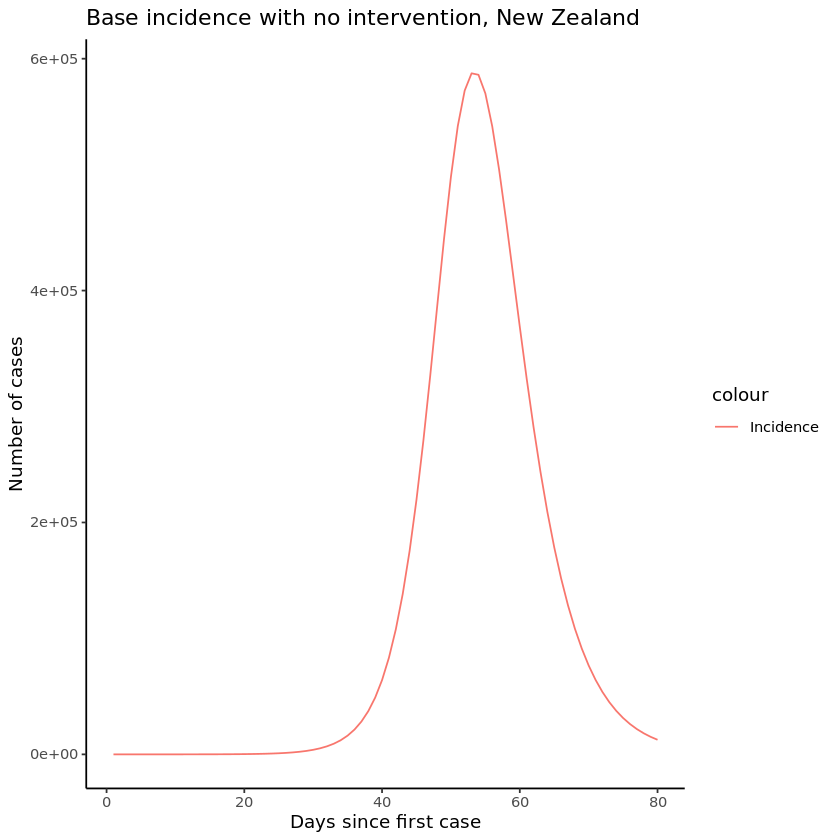

In [124]:
fit_nz %>%
 ggplot(aes(x = time)) +
 geom_line(aes(y = I_nz, colour = "I")) + 
 geom_line(aes(y = S_nz, colour = "S")) +
 geom_line(aes(y = R_nz, colour = "R")) +
 theme_classic() + 
 ggtitle("SIR model of New Zealand") +
 xlab("Days since first case") +
 ylab("Number of cases") + 
 ggsave("sir_model_base.jpg")

fit_nz %>%
 ggplot(aes(x = time)) +
 geom_line(aes(y = I_nz, colour = "Incidence")) + 
 theme_classic() + 
 ggtitle("Base incidence with no intervention, New Zealand") +
 xlab("Days since first case") +
 ylab("Number of cases") + 
 ggsave("incidence_base.jpg")


In [123]:
comp_noint <- composite_nums
comp_noint

,r0_nz,max_infected_nz,severe_cases_nz,intensive_nz,poss_deaths_nz
R0,1.799227,587385,117477,35243,4112


In [126]:
## what would happen with different levels of interventions?
# use stochastic compartmental models
# run SIR model
# run for 100 days one day at a time
# average over 10 runs

control <- control.icm(type = "SIR",
                      nsteps = 100,
                      nsims = 10)

## Susceptible = 997
## infected = 3
# removed = 0 to start with

init <- init.icm(s.num = 997,
                i.num = 3,
                r.num = 0)
## parametrise the models
## NZ death rate: 7.6 / 1000 
## (https://www.indexmundi.com/new_zealand/death_rate.html)
# act.rate = rate at which susceptible are exposed to inf
# inf.prob = prob of infection at each encounter
# arrival rate = a.rate, set at 1.5 * death rate (d.rate)
# departure rates for each compartment
# ds.rate, di.rate, dr.rate
# exposure to infection  10 times/day
# prob of infection = 0.05 (5% chance of infection)
# recovery rate = 20 days, rec.rate =  1/20

param <- param.icm(inf.prob = 0.05,
                  act.rate = 10,
                  rec.rate = 1/20,
                  a.rate = (11.5/365)/1000,
                  ds.rate = (7.6/365)/1000,
                  di.rate = (15/365)/1000,
                  dr.rate = (7.6/365)/1000 ) 
                   


In [130]:
# run the simulation
sim <- icm(param, init, control)
simdf <- as.data.frame(sim)

In [131]:
# no intervention, 
simdf %>% head()

sim,time,s.num,i.num,num,r.num,si.flow,ir.flow,ds.flow,di.flow,dr.flow,a.flow
<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,997,3,1000,0,0,0,0,0,0,0
1,2,997,2,1000,1,0,1,0,0,0,0
1,3,996,3,1000,1,1,0,0,0,0,0
1,4,996,3,1000,1,0,0,0,0,0,0
1,5,994,5,1000,1,2,0,0,0,0,0
1,6,992,6,1000,2,2,1,0,0,0,0


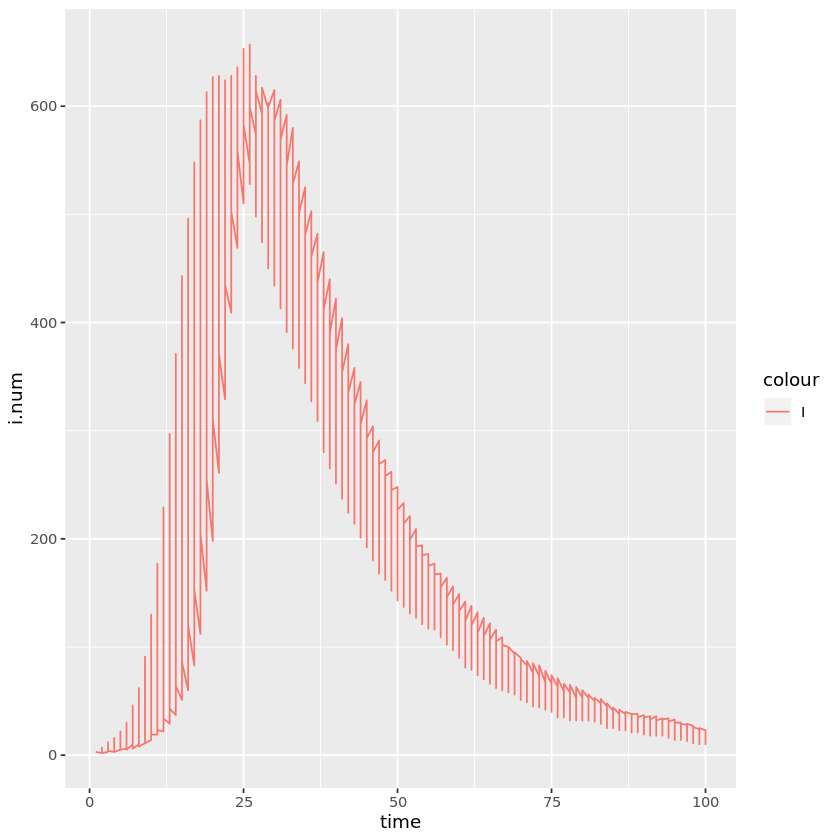

In [133]:
simdf %>%
 ggplot(aes(x = time)) +
 geom_line(aes(y = i.num, colour = "I"))

In [139]:
jpeg("simplot.jpg")
plot(sim, y = "si.flow") 
dev.off()

png 
  2

In [148]:
# write a function

run_sir <- function(inf_prob, act_rate, pop_size = 10000,
                   i_num = 3, n_steps = 100,
                   n_sims = 10,
                   si_mean = 7.5,
                   si_sd = 3.4) {
    
    param <- param.icm(inf.prob = inf_prob,
                      act.rate = act_rate,
                      rec.rate = 1/20,
                      a.rate = (11.5/365)/1000,
                  ds.rate = (7.6/365)/1000,
                  di.rate = (15/365)/1000,
                  dr.rate = (7.6/365)/1000 )
    init <- init.icm(s.num = pop_size - i_num,
                    i.num = i_num,
                    r.num = 0)
    control <- control.icm(type = "SIR",
                          nsteps = n_steps,
                          nsims = n_sims)
    sim <- icm(param, init, control)
    
    inc_rates <- as.data.frame(sim, out = "mean") %>%
     select(time, si.flow, i.num) %>%
     mutate(act_rate = act_rate,
           inf_prob = inf_prob,
           total_cases = sum(si.flow),
           max_prev = max(i.num, na.rm = T))
    
    local_case_dates <- inc_rates %>% 
       filter(time <= 200,
             act.rate == act_rate,
             inf.prob == inf_prob) %>%
       select(time, si.flow) %>%
       uncount(si.flow) %>%
       pull(time)
    return(inc_rates)
     
}

In [149]:
# empty data frame to append results from simulation

sims_inc <- tibble(time = integer(0),
                  si.flow = numeric(0),
                  i.num = numeric(0),
                  act_rate = numeric(0),
                  inf_prob = numeric(0),
                  total_cases = numeric(0),
                  max_prev = numeric(0))

# parameters to step through
act.rates <- c(10, 5, 2)
inf.probs <- c(0.05, 0.025, 0.01)

## loop through

for(act.rate in act.rates){
    for(inf.prob in inf.probs){
        sims_inc <- sims_inc %>%
          bind_rows(run_sir(inf.prob, act.rate))
    }
}

In [150]:
library(ggridges)

In [151]:
# install.packages("ggridges")

In [187]:
sims_inc %>% tail()

time,si.flow,i.num,act_rate,inf_prob,total_cases,max_prev,intervention_level_label,act_rate_facet_label,inf_prob_facet_label
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<fct>,<fct>
95,0,0.4,2,0.01,2.1,3.1,"2 exp/day, 1 % inf risk/exp",2 exposures per day,Probability of infection at each exposure: 0.01
96,0,0.3,2,0.01,2.1,3.1,"2 exp/day, 1 % inf risk/exp",2 exposures per day,Probability of infection at each exposure: 0.01
97,0,0.2,2,0.01,2.1,3.1,"2 exp/day, 1 % inf risk/exp",2 exposures per day,Probability of infection at each exposure: 0.01
98,0,0.2,2,0.01,2.1,3.1,"2 exp/day, 1 % inf risk/exp",2 exposures per day,Probability of infection at each exposure: 0.01
99,0,0.1,2,0.01,2.1,3.1,"2 exp/day, 1 % inf risk/exp",2 exposures per day,Probability of infection at each exposure: 0.01
100,0,0.1,2,0.01,2.1,3.1,"2 exp/day, 1 % inf risk/exp",2 exposures per day,Probability of infection at each exposure: 0.01


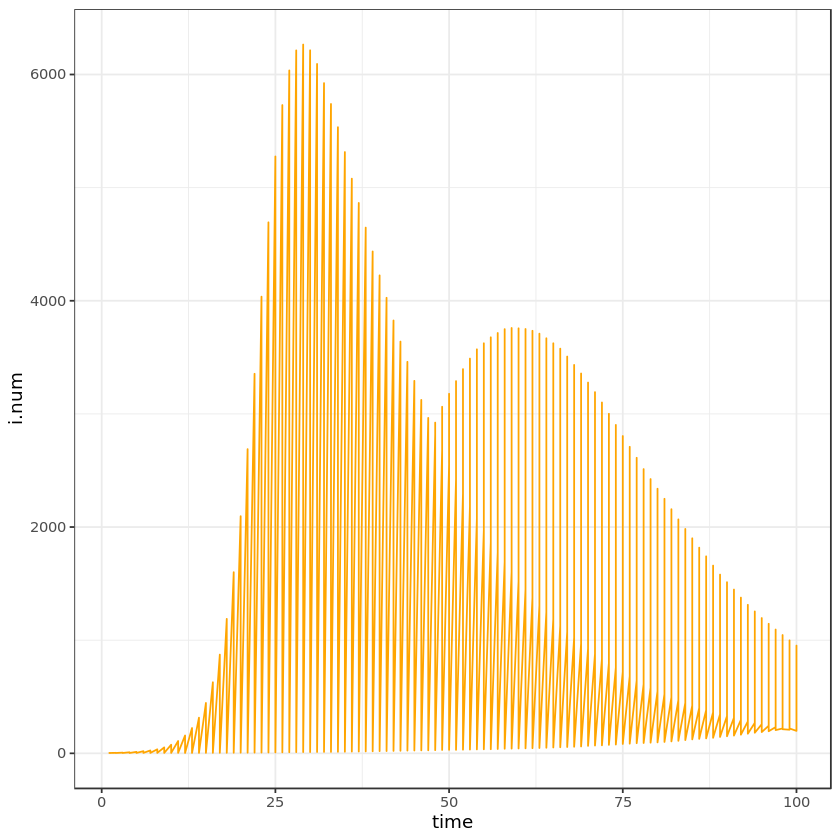

In [186]:

sims_inc %>% 
 filter(act_rate == 10) %>%
 ggplot() +
 geom_line(aes(x = time, y = i.num), colour = "orange") +
 theme_bw()

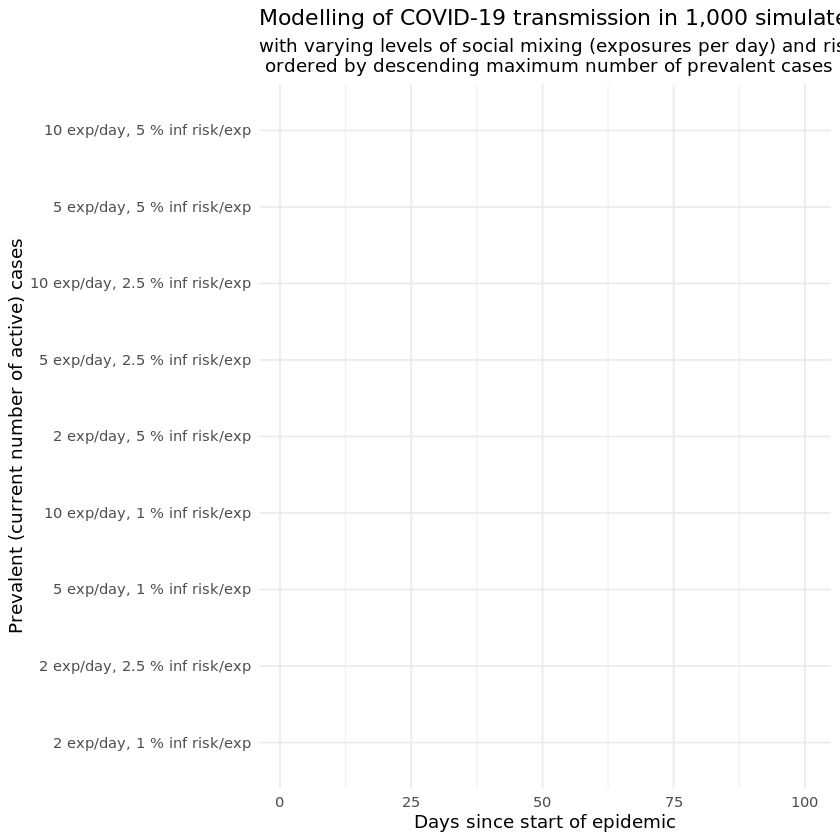

In [164]:
sims_inc <- sims_inc %>% mutate(intervention_level_label = paste(act_rate, 
    "exp/day,", inf_prob * 100, "% inf risk/exp")) %>% arrange(max_prev, 
    time) %>% mutate_at(vars(intervention_level_label), funs(factor(., 
    levels = unique(.), ordered = TRUE)))

sims_inc %>% filter(time <= 100) %>% ggplot(aes(x = time, 
    y = intervention_level_label, height = i.num, fill = intervention_level_label)) + 
    labs(x = "Days since start of epidemic", y = "Prevalent (current number of active) cases", 
        title = "Modelling of COVID-19 transmission in 1,000 simulated people", 
        subtitle = paste("with varying levels of social mixing (exposures per day)", 
            "and risk of infection at each exposure,\n", "ordered by descending maximum number of prevalent cases per day")) + 
    theme_minimal() + theme(legend.position = "top", strip.text = element_text(size = 12)) + 
    scale_fill_brewer(type = "seq", palette = "Oranges")

In [1]:
sims_inc <- sims_inc %>% mutate(act_rate_facet_label = paste(act_rate, 
    "exposures per day"), inf_prob_facet_label = paste("Probability of infection\nat each exposure:", 
    inf_prob)) %>% arrange(desc(act_rate)) %>% mutate_at(vars(act_rate_facet_label), 
    funs(factor(., levels = unique(.)))) %>% arrange(desc(inf_prob)) %>% 
    mutate_at(vars(inf_prob_facet_label), funs(factor(., levels = unique(.)))) %>% 
    arrange(desc(act_rate), desc(inf_prob), time)

# add annotation text for each facet


sims_inc %>% filter(time <= 365) %>% ggplot(aes(x = time, 
    y = i.num)) + geom_line(colour = "blue", size = 1.5) + 
    facet_grid(inf_prob_facet_label ~ act_rate_facet_label) + 
    labs(x = "Days since start of epidemic", 
    y = "Total number of cases", title = "Total cases of covid 19 for different scenarios", 
    subtitle = paste("with varying levels of social mixing", 
        "& probabilities of infection at each exposure")) + 
    theme(legend.position = "top", strip.text = element_text(size = 10)) +
    theme_bw() +
    ggsave("whatif.jpg")

ERROR: Error in sims_inc %>% mutate(act_rate_facet_label = paste(act_rate, "exposures per day"), : could not find function "%>%"


country,cases,date,days
<chr>,<dbl>,<date>,<int>
India,1,2020-01-30,1
India,1,2020-01-31,2
India,1,2020-02-01,3
India,2,2020-02-02,4
India,3,2020-02-03,5
India,3,2020-02-04,6


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


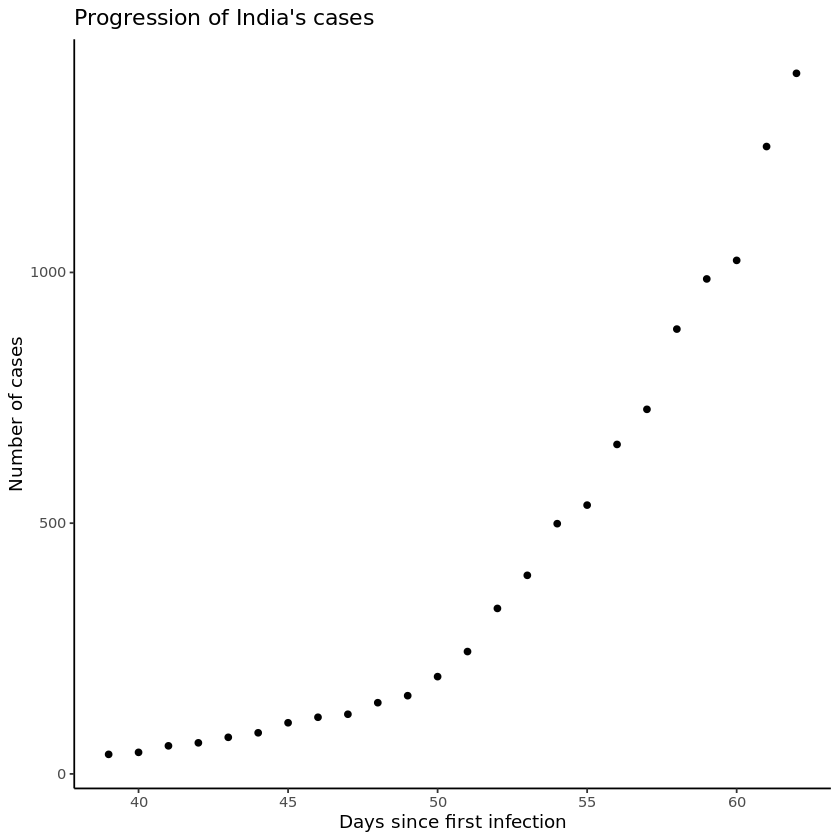

time,S_india,I_india,R_india
<dbl>,<dbl>,<dbl>,<dbl>
1,119999961,39.00000,0.00000
2,119999937,45.68939,17.78354
3,119999908,53.52617,38.61737
4,119999874,62.70712,63.02467
5,119999835,73.46279,91.61837
6,119999789,86.06329,125.11654


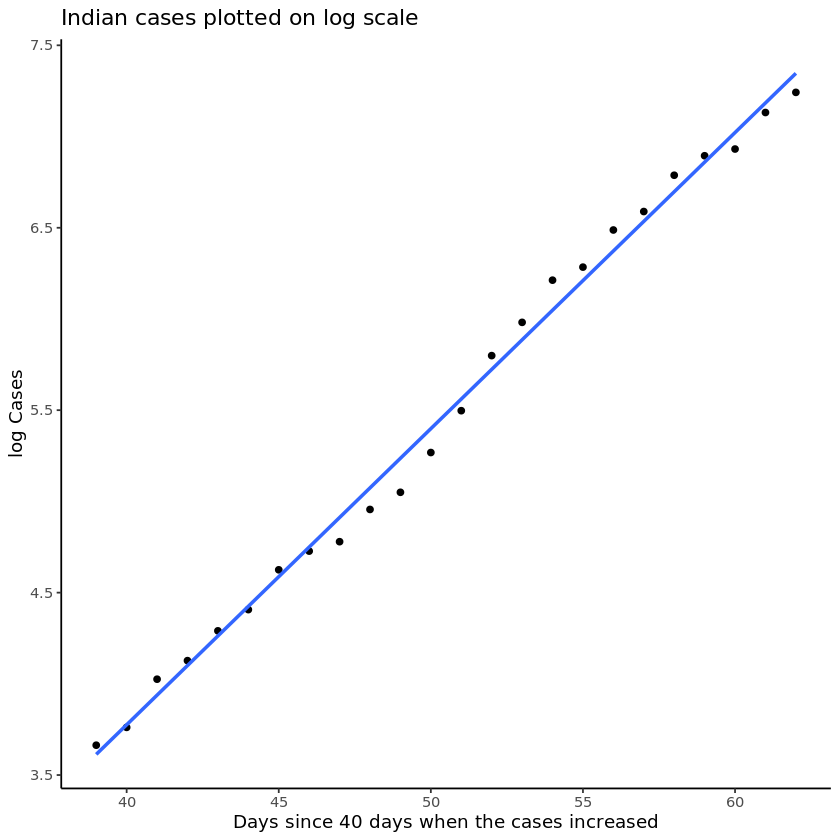

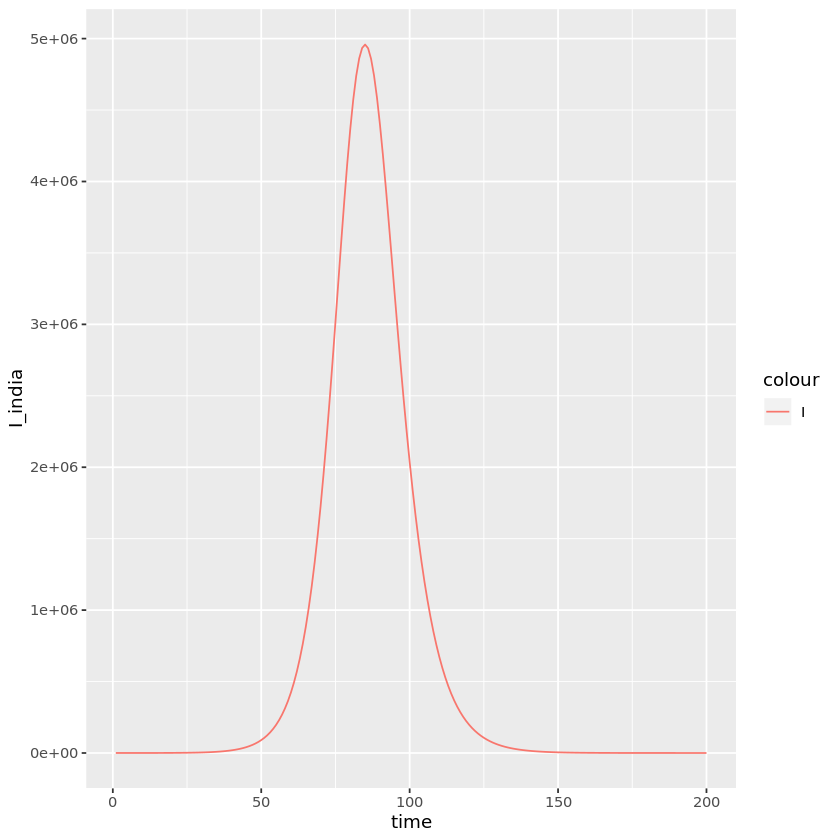

In [22]:
## the picture of India and simple sir modelling

# rename country/Region to country and remove province and lat long first
india_data <- rawdata %>%
  rename(country = `Country/Region`) %>%
  select(-`Province/State`, -Lat, -Long) %>%
  pivot_longer(-country,
              names_to = "mo_day_yr",
              values_to = "cases") %>%
  mutate(date = mdy(mo_day_yr) ) %>%
  select(-mo_day_yr) %>%
   filter(country == "India") %>%
   filter(cases >= 1) %>%
   mutate(days = 1:length(cases))

india_data %>% head() # India's first case was in 30th January, 2020

## graph India's growth
india_data <- india_data %>%
  filter(days > 38)

india_data %>%
  ggplot(aes(x = days)) +
  geom_point(aes(y = cases)) +
  ggtitle("Progression of India's cases") +
  xlab("Days since first infection") +
  ylab("Number of cases") +
  theme_classic() +
  ggsave("india_cases.jpg")

india_data %>%
  ggplot(aes(x = days)) +
  geom_point(aes(y = log(cases))) +
  geom_smooth(method = lm, se = F,
              aes(y = log(cases))) +
  ggtitle("Indian cases plotted on log scale") +
  xlab("Days since 40 days when the cases increased") +
  ylab("log Cases") +
  theme_classic() +
  ggsave("india_log.jpg")

## sim modelling for India

## first define the sir function

I_india = india_data$cases
N_india = 120000000 # 1.2 billion people
days_in = india_data$days

## Initialise values

init_in <- c(S_india = N_in - I_india[1],
          I_india = I_in[1],
          R_india = 0
         )
## Specify the model

sir_in <- function(time, state, params){
    params <- as.list(c(state, params))
    with(params, {
        dS <- - beta * I_india * S_india / N_india
        dI <- beta * I_india * S_india / N_india - gamma * I_india
        dR <- gamma * I_india
        list(c(dS, dI, dR))
    })
}


## get the minimised sum of squares

rss_in <- function(params){
    names(params) <- c("beta", "gamma")
    out <- ode(y = init_in,
              times = days_in,
              func = sir_in,
              parms = params)
    fit <- out[,3]
    sum((I_india - fit)^2)
}

## optimise the model

optimised_in <- optim(c(0.5, 0.5),
                  rss_in,
                  method = "L-BFGS-B",
                  lower = c(0,0),
                  upper = c(1,1))
optim_params_in <- setNames(optimised_in$par,
                            c("beta", "gamma"))
## set the time
t_in <- 1:200 # time in days

## evaluate the model 
fit_in <- data.frame(ode(y = init_in,
                        times = t_in,
                        func = sir_in,
                        parm = optim_params_in ))

fit_in %>% head()



,r0_in,max_infected_in,severe_cases_in,intensive_in,poss_deaths_in
R0,1.376157,4958356,991671,297501,34708


Saving 6.67 x 6.67 in image


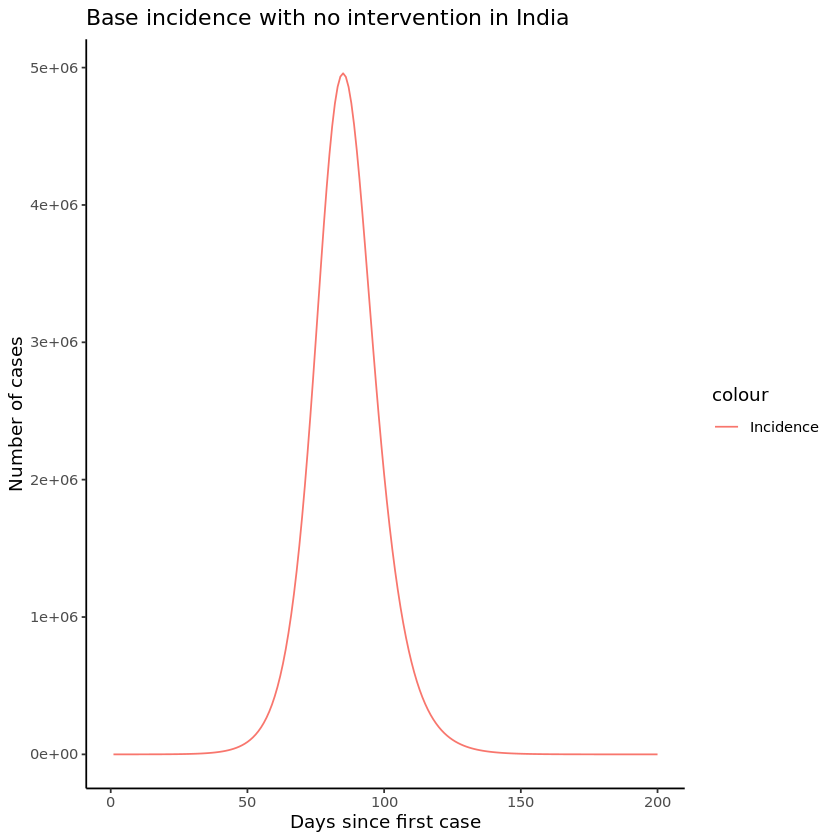

In [23]:
## estimate the R0

r0_in <- setNames(optim_params_in["beta"] / optim_params_in["gamma"],
                 "R0")


## maximum infected
max_infected_in <- round(max(fit_in$I_india), 0)

## severe cases (20% cases severe)

severe_cases_in = round(0.20 * max_infected_in, 0)

## how many will need intensive care
## 6% of infected cases

intensive_in <- round(max_infected_in * 0.06, 0)

## possible deaths 0.7% fatality

poss_deaths_in <- round(max_infected_in * 0.007, 0)

composite_nums_in <- cbind(r0_in, max_infected_in,
                           severe_cases_in,
                           intensive_in,
                           poss_deaths_in)

## Get the outputs from the model
composite_nums_in

## Graph the incident cases

fit_in %>%
 ggplot(aes(x = time)) +
 geom_line(aes(y = I_india, colour = "Incidence")) + 
 theme_classic() + 
 ggtitle("Base incidence with no intervention in India") +
 xlab("Days since first case") +
 ylab("Number of cases") + 
 ggsave("incidence_in_uncontrolled.jpg")

In [18]:
fit_in %>% head()

time,S_in,I_in,R_in
<dbl>,<dbl>,<dbl>,<dbl>
1,119999961,39.00000,0.00000
2,119999937,45.68939,17.78354
3,119999908,53.52617,38.61737
4,119999874,62.70712,63.02467
5,119999835,73.46279,91.61837
6,119999789,86.06329,125.11654


In [24]:
optim_params_in

beta     gamma 
0.5791524 0.4208476